In [1]:
!git clone https://github.com/matterport/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 111.81 MiB | 35.64 MiB/s, done.
Resolving deltas: 100% (571/571), done.


In [2]:
%cd /content/Mask_RCNN

/content/Mask_RCNN


In [3]:
!pip3 install -r requirements.txt

     |████████████████████████████████| 163kB 2.8MB/s 
     |████████████████████████████████| 204kB 52.9MB/s 


In [4]:
!python3 setup.py install

running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/mrcnn
copying mrcnn/utils.py -> build/lib/mrcnn
copying mrcnn/model.py -> build/lib/mrcnn
copying mrcnn/__init__.py -> build/lib/mrcnn
copying mrcnn/visualize.py -> build/lib/mrcnn
copying mrcnn/config.py -> build/lib/mrcnn
copying mrcnn/parallel_model.py -> build/lib/mrcnn
creating build/bdist.linux-x86_64
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/utils.py -> build/bdist.linux-x86_64/egg/mrcnn

In [5]:
!git clone https://gitlab.com/simon-staudenmann/get-the-fox-data.git

Cloning into 'get-the-fox-data'...
remote: Enumerating objects: 7265, done.
remote: Counting objects: 100% (7265/7265), done.
remote: Compressing objects: 100% (7262/7262), done.
remote: Total 7265 (delta 6), reused 7262 (delta 3)
Receiving objects: 100% (7265/7265), 1.13 GiB | 29.90 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Checking out files: 100% (6032/6032), done.


In [6]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("/content/Mask_RCNN")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


... done downloading pretrained model!


In [0]:
from mrcnn.config import Config
class GetTheFox(Config):
    NAME = "get-the-fox"
    NUM_CLASSES = 1 + 5  # background + 5 classes

    STEPS_PER_EPOCH = 2812
    VALIDATION_STEPS = 313
    #LEARNING_RATE = 1e-5

    IMAGES_PER_GPU = 1

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    #TRAIN_ROIS_PER_IMAGE = 32
    
config = GetTheFox()

In [0]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split
import skimage
import cv2

class GetTheFoxDataset(utils.Dataset):

  def f(self, x):
    path = f'{ROOT_DIR}/get-the-fox-data/data/{x}.jpg'
    image = cv2.imread(path, 0)
    height, width = image.shape
    self.add_image('', x, path, imageID=x, height=height, width=width)

  def load_dataset(self, subset):
    self.add_class('', 1, 'Fox')
    self.add_class('', 2, 'Person')
    self.add_class('', 3, 'Dog')
    self.add_class('', 4, 'Cat')
    self.add_class('', 5, 'Chicken')
    
    df = pd.read_parquet(f'{ROOT_DIR}/get-the-fox-data/df.parquet')
    train, validation = train_test_split(df, test_size=0.1, random_state=420)

    if subset == 'train':
      train['ImageID'].apply(lambda x: self.f(x))
    elif subset == 'validation':
      validation['ImageID'].apply(lambda x: self.f(x))

  def load_mask(self, image_id):
    df = pd.read_parquet(f'{ROOT_DIR}/get-the-fox-data/df.parquet')
    imageID = self.image_info[image_id]['imageID']
    height = self.image_info[image_id]['height']
    width = self.image_info[image_id]['width']
    temp = df[df['ImageID'] == imageID]
    maskPaths = temp['MaskPath'].to_list()
    labels = temp['Label'].to_list()

    masks = []
    for path in maskPaths:
      mask = cv2.imread(f'{ROOT_DIR}/get-the-fox-data/mask/{path}', 0)
      mask = cv2.resize(mask, (width, height))
      masks.append(mask)
    masks = np.dstack(masks)

    class_ids = []
    for label in labels:
      class_id = self.class_names.index(label)
      class_ids.append(class_id)
    class_ids = np.array(class_ids)

    return masks, class_ids

In [0]:
# Training dataset
dataset_train = GetTheFoxDataset()
dataset_train.load_dataset('train')
dataset_train.prepare()

# Validation dataset
dataset_val = GetTheFoxDataset()
dataset_val.load_dataset('validation')
dataset_val.prepare()

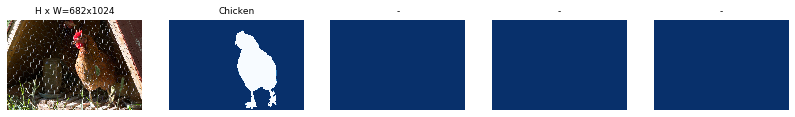

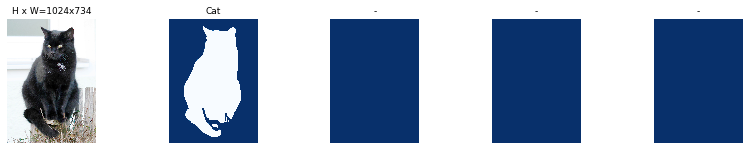

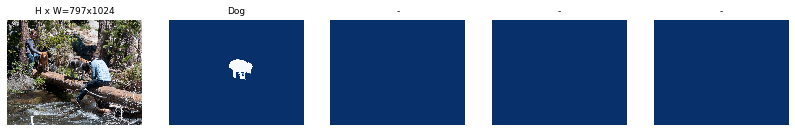

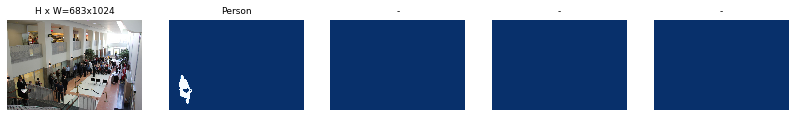

In [15]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [16]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [17]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

In [18]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
history = model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=10, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/Mask_RCNN/logs/get-the-fox20191112T2002/mask_rcnn_get-the-fox_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrc

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'




Epoch 1/10
2812/2812 [==============================] - 1377s 490ms/step - loss: 1.1115 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.3927 - mrcnn_class_loss: 0.0968 - mrcnn_bbox_loss: 0.3190 - mrcnn_mask_loss: 0.2878 - val_loss: 1.1759 - val_rpn_class_loss: 0.0153 - val_rpn_bbox_loss: 0.5772 - val_mrcnn_class_loss: 0.0820 - val_mrcnn_bbox_loss: 0.2577 - val_mrcnn_mask_loss: 0.2437

Epoch 2/10
2812/2812 [==============================] - 1340s 477ms/step - loss: 0.9490 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.3940 - mrcnn_class_loss: 0.0703 - mrcnn_bbox_loss: 0.2206 - mrcnn_mask_loss: 0.2521 - val_loss: 1.0389 - val_rpn_class_loss: 0.0120 - val_rpn_bbox_loss: 0.4327 - val_mrcnn_class_loss: 0.0541 - val_mrcnn_bbox_loss: 0.2630 - val_mrcnn_mask_loss: 0.2771
Epoch 3/10
2812/2812 [==============================] - 1336s 475ms/step - loss: 0.7948 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.2998 - mrcnn_class_loss: 0.0568 - mrcnn_bbox_loss: 0.1898 - mrcnn_mask_loss: 0.2384 - val_loss: 0.8

In [0]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

In [58]:
class InferenceConfig(GetTheFox):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
epoch = 5
model_path = os.path.join(ROOT_DIR, f'logs/get-the-fox20191112T2002/mask_rcnn_get-the-fox_{str(epoch).zfill(4)}.h5')
# model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /content/Mask_RCNN/logs/get-the-fox20191112T2002/mask_rcnn_get-the-fox_0005.h5
Re-starting from epoch 5


original_image           shape: (256, 256, 3)         min:    0.00000  max:  245.00000  uint8
image_meta               shape: (18,)                 min:    0.00000  max: 1024.00000  float64
gt_class_id              shape: (1,)                  min:    4.00000  max:    4.00000  int64
gt_bbox                  shape: (1, 4)                min:    0.00000  max:  224.00000  int32
gt_mask                  shape: (256, 256, 1)         min:    0.00000  max:  255.00000  uint8


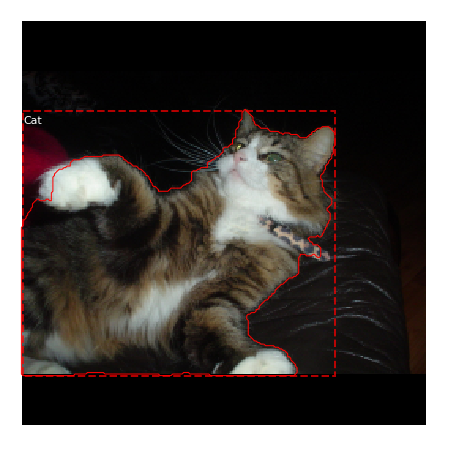

In [68]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  245.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  138.10000  float64
image_metas              shape: (1, 18)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32


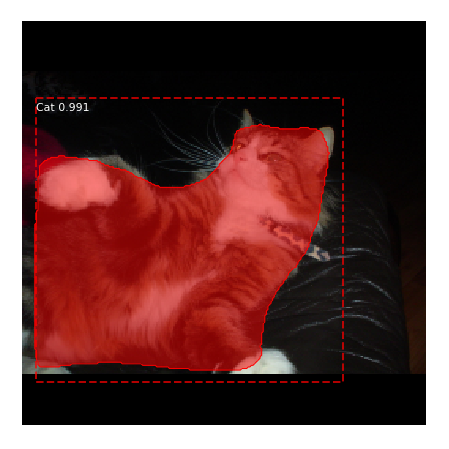

In [69]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [61]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = dataset_val.image_ids
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))
print("precision: ", np.mean(precisions))
print("recall: ", np.mean(recalls))

mAP:  0.5352204727728437
precision:  0.6666666666666666
recall:  0.5
